# STEP 7: Vary parameters of the ML model manually

This section was inspired by [In Depth: Parameter tuning for SVC](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769)

In this section, the 4 SVC parameters `kernel`, `gamma`, `C` and `degree` will be introduced one by one. Furthermore, their influence on the classification result by varying these single parameters will be shown.

**Disclaimer:** In order to show the effects of varying the individual parameters in 2D graphs, only the best correlating variables `petal_length` and `petal_width` are used to train the SVC.

## Prepare dataset

In this section the dataset [palmerpenguins @allisonhorst](https://github.com/allisonhorst/palmerpenguins) is used.

Further references on the use of this dataset in a classification can be found here:

- [penguin dataset : The new Iris @kaggle](https://www.kaggle.com/code/parulpandey/penguin-dataset-the-new-iris/notebook)
- [Support Vector Machines (SVM) in Python with Sklearn](https://datagy.io/python-support-vector-machines/)

In [17]:
from seaborn import load_dataset, pairplot
import seaborn as sns
import matplotlib.pyplot as plt

# loading and explore the penguin dataset
penguin_df = load_dataset('penguins')

# save dataset to CSV file
penguin_df.to_csv('./datasets/penguins_seaborn_stripped.csv', index=False)

penguin_df.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,Female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,Male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


In [10]:
penguin_df_gaps = penguin_df[penguin_df.isnull().any(axis=1)]

# highlight cells with nan values
penguin_df_gaps = penguin_df_gaps.style.highlight_null('yellow')

penguin_df_gaps

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,nan,nan,nan,nan,nan
8,Adelie,Torgersen,34.100000,18.100000,193.000000,3475.000000,nan
9,Adelie,Torgersen,42.000000,20.200000,190.000000,4250.000000,nan
10,Adelie,Torgersen,37.800000,17.100000,186.000000,3300.000000,nan
11,Adelie,Torgersen,37.800000,17.300000,180.000000,3700.000000,nan
47,Adelie,Dream,37.500000,18.900000,179.000000,2975.000000,nan
246,Gentoo,Biscoe,44.500000,14.300000,216.000000,4100.000000,nan
286,Gentoo,Biscoe,46.200000,14.400000,214.000000,4650.000000,nan
324,Gentoo,Biscoe,47.300000,13.800000,216.000000,4725.000000,nan
336,Gentoo,Biscoe,44.500000,15.700000,217.000000,4875.000000,nan


In [18]:
# drop missing records
penguin_df_dropped = penguin_df.dropna()

print("Old data frame length:", len(penguin_df))
print("New data frame length:", len(penguin_df_dropped))
print("Number of rows with at least 1 NaN value: ", 
      (len(penguin_df)-len(penguin_df_dropped)))

Old data frame length: 344
New data frame length: 333
Number of rows with at least 1 NaN value:  11


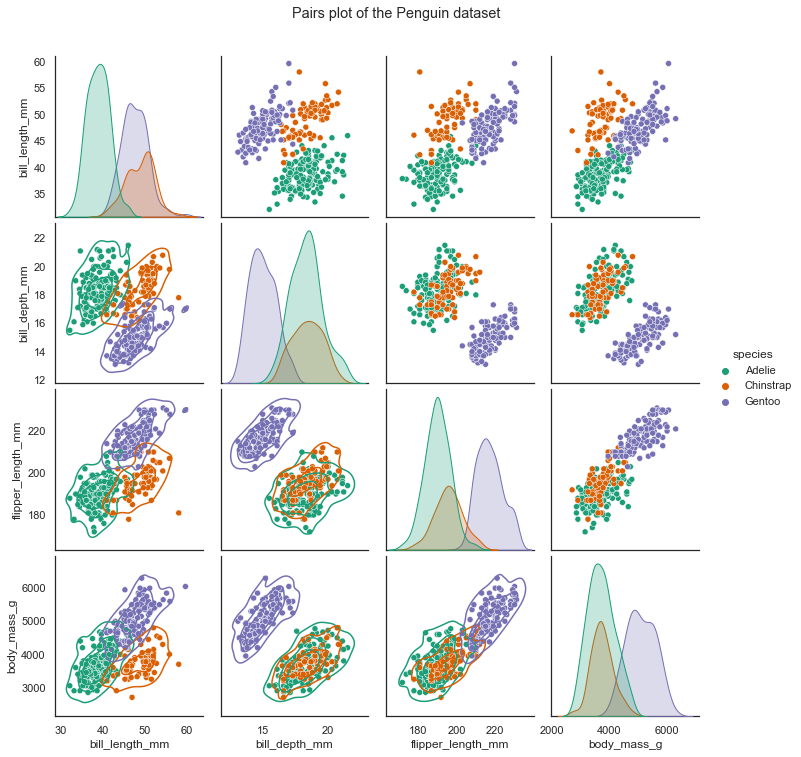

In [19]:
# plot the penguin species features in a pairs plot
sns.set(font_scale=1.0)
sns.set_style("white")

g = sns.pairplot(penguin_df_dropped, diag_kind="kde", hue='species', 
                 palette='Dark2', height=2.5)

g.map_lower(sns.kdeplot, levels=4, color=".2")
# y .. padding between title and plot
g.fig.suptitle('Pairs plot of the Penguin dataset', y=1.05)
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np

# import iris dataset again
irisdata_df = pd.read_csv('./datasets/IRIS_flower_dataset_kaggle.csv')

# encode the class column from class strings to integer equivalents
irisdata_df_enc = irisdata_df.replace({"species":  {"Iris-setosa":0,
                                                    "Iris-versicolor":1, 
                                                    "Iris-virginica":2}})
#irisdata_df_enc

### Prepare datasets for parameter variation and plotting

These datasets will  be used for parameter variation and plotting only. In particular, for later **2D plotting** of the effects of parameter variation, only **2 variables** of the iris dataset can be used.

However, as seen in the previous section, this selection is very much at the expense of detection accuracy. Therefore, it is not useful to make predictions with this subset of data - it is not necessary to divide it into a training and a test dataset.

In [ ]:
# copy only 2 feature columns
# and convert pandas dataframe to numpy array
X_plot = irisdata_df_enc[['petal_length', 'petal_width']].to_numpy(copy=True)
#X_plot = irisdata_df_enc[['sepal_length', 'sepal_width']].to_numpy(copy=True)
#X_plot

In [ ]:
# convert pandas dataframe to numpy array
# and get a flat 1D copy of 2D numpy array
y_plot = irisdata_df_enc[['species']].to_numpy(copy=True).flatten()
#y_plot

### Prepare dataset for prediction and evaluation

To **evaluate the recognition accuracy** by parameter variation, the complete iris dataset with all variables must be used. To make predictions with test data, the dataset is again divided into a training and a test dataset.

In [ ]:
X = irisdata_df.drop('species', axis=1)
y = irisdata_df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True)

## Plotting functions

This function helps to visualize the modifications by varying the individual SVC parameters:

In [ ]:
def plotSVC(title, svc, X, y, xlabel, ylabel):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # prevent division by zero
    if x_min == 0.0:
        x_min = 0.1
    
    h = (x_max / x_min)/1000
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.subplot(1, 1, 1)
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()

This function cares for cross validation:

In [ ]:
def crossValSVC(X_train, y_train, kernel='rbf', gamma='scale', C=1.0, degree=3):
    # train the SVC
    svc = svm.SVC(kernel=kernel, 
                  gamma=gamma, 
                  C=C, 
                  degree=degree).fit(X_train, y_train)
    # calculate accuracies
    accuracies = cross_val_score(estimator = svc, X = X_train, 
                                 y = y_train, cv = 10)
    
    accuracy = accuracies.mean()*100
    return accuracy

This function plots the variation of the SVC parameters against the prediction accuracy to show the effect of variation and its limits regarding the phenomenon **overfitting**:

In [ ]:
def plotParamsAcc(param_list, acc_list, param_name, log_scale=False):
    fig, ax = plt.subplots(figsize=(10,6))
    title_str = 'Variation of {} parameter '.format(param_name) \
                +'and its effect to prediction accuracy'
    plt.title(title_str)
    ax.plot(param_list, accuracy_list)
    if log_scale:
        # set the X axis scale to logarithmic
        ax.set_xscale('log')
    plt.xlabel(param_name)
    plt.ylabel('accuracy [%]')
    plt.grid()
    plt.show()

## Vary `kernel` of SVC

The `kernel` parameter selects the type of hyperplane that is used to separate the data. Using `linear` ([linear classifier](https://en.wikipedia.org/wiki/Linear_classifier)) kernel will use a linear hyperplane (a line in the case of 2D data). The `rbf` ([radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)) and `poly` ([polynomial kernel](https://en.wikipedia.org/wiki/Polynomial_kernel)) kernel use non linear hyperplanes. The **default** is `kernel=rbf`.

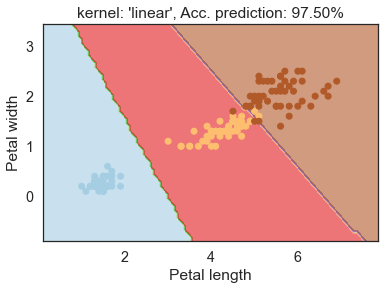

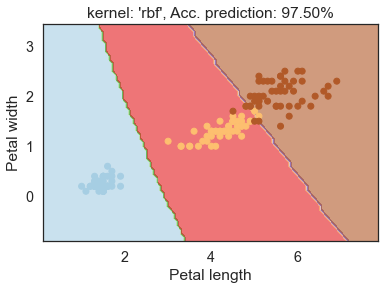

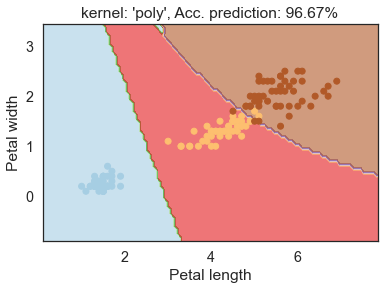

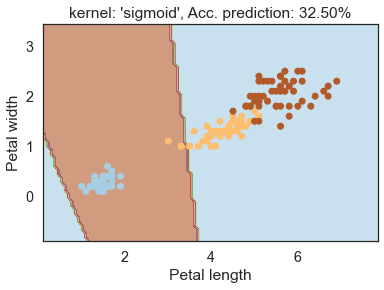

In [ ]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

xlabel = 'Petal length'
ylabel = 'Petal width'

for kernel in kernels:
    svc_plot = svm.SVC(kernel=kernel).fit(X_plot, y_plot)
    accuracy = crossValSVC(X_train, y_train, kernel=kernel)
    title_str = 'kernel: \''+str(kernel)+'\', '+'Acc. prediction: {:.2f}%'.format(accuracy)
    plotSVC(title_str, svc_plot, X_plot, y_plot, xlabel, ylabel)

## Vary `gamma` parameter

The `gamma` parameter is used for **non linear hyperplanes**. The higher the `gamma` float value it tries to exactly fit the training dataset. The **default** is `gamma='scale'`.

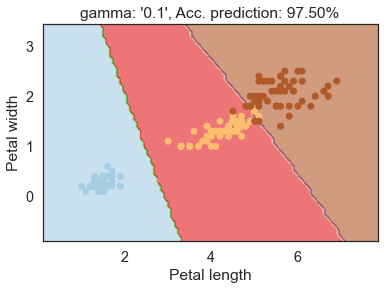

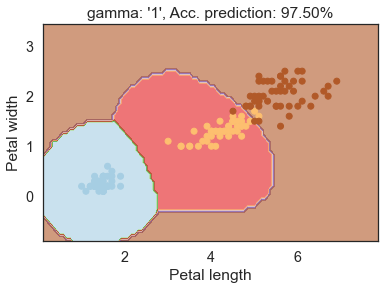

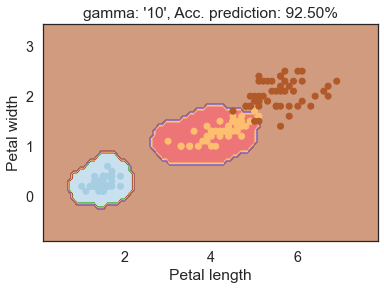

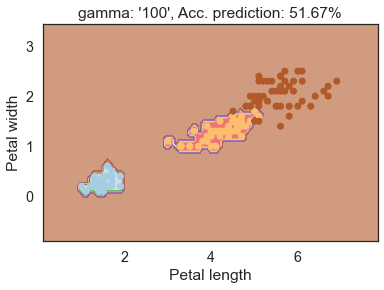

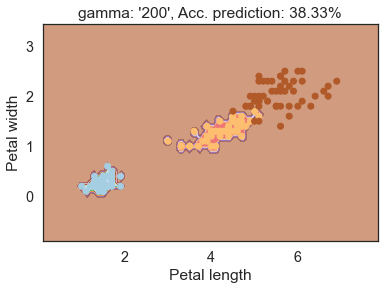

In [ ]:
gammas = [0.1, 1, 10, 100, 200]

xlabel = 'Petal length'
ylabel = 'Petal width'

for gamma in gammas:
    svc_plot = svm.SVC(kernel='rbf', gamma=gamma).fit(X_plot, y_plot)
    accuracy = crossValSVC(X_train, y_train, kernel='rbf', gamma=gamma)
    title_str = 'gamma: \''+str(gamma)+'\', ' \
                +'Acc. prediction: {:.2f}%'.format(accuracy)
    plotSVC(title_str, svc_plot, X_plot, y_plot, xlabel, ylabel)

Show the variation of the SVC parameter `gamma` against the **prediction accuracy**.

As we can see, increasing `gamma` leads to **overfitting** as the classifier tries to perfectly fit the training data.

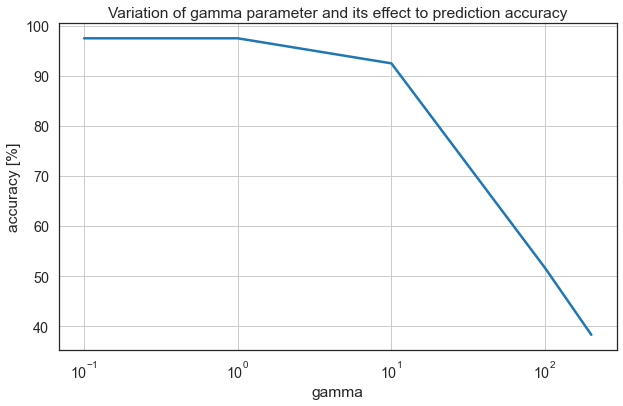

In [ ]:
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 200]

accuracy_list = list()
for gamma in gammas:
    accuracy = crossValSVC(X_train, y_train, kernel='rbf', gamma=gamma)
    accuracy_list.append(accuracy)

plotParamsAcc(gammas, accuracy_list, 'gamma', log_scale=True)

## Vary `C` parameter

The `C` parameter is the **penalty** of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly. The **default** is `C=1.0`.

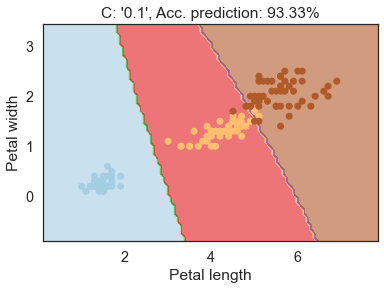

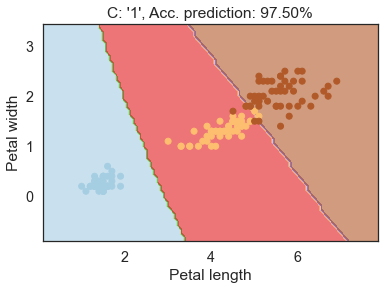

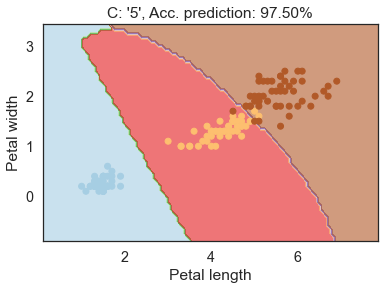

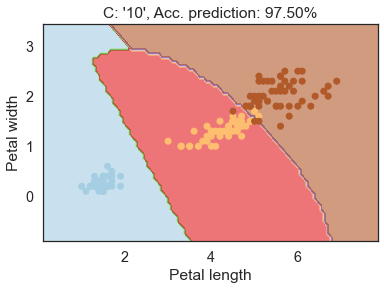

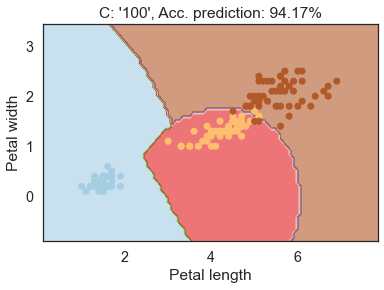

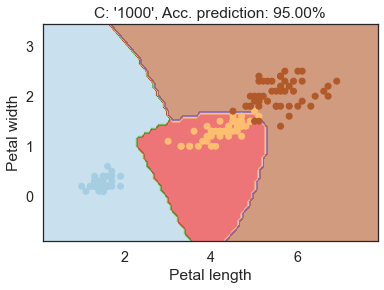

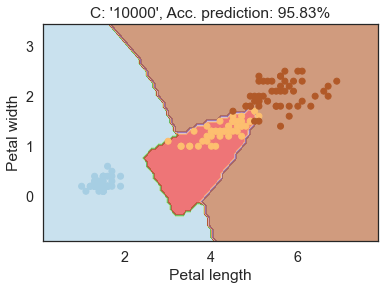

In [ ]:
cs = [0.1, 1, 5, 10, 100, 1000, 10000]

xlabel = 'Petal length'
ylabel = 'Petal width'

for c in cs:
    svc_plot = svm.SVC(kernel='rbf', C=c).fit(X_plot, y_plot)
    accuracy = crossValSVC(X_train, y_train, kernel='rbf', C=c)
    title_str = 'C: \''+str(c)+'\', ' \
                 +'Acc. prediction: {:.2f}%'.format(accuracy)
    plotSVC(title_str, svc_plot, X_plot, y_plot, xlabel, ylabel)

Show the variation of the SVC parameter `C` against the **prediction accuracy**.

But be careful: to high `C` values may lead to **overfitting** the training data.

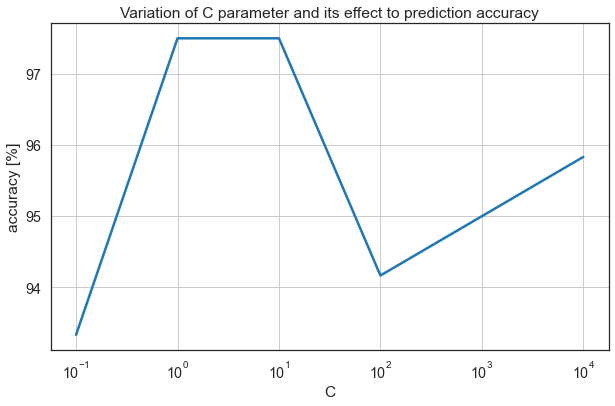

In [ ]:
cs = [0.1, 1, 5, 6, 7, 8, 10, 100, 1000, 10000]

accuracy_list = list()
for c in cs:
    accuracy = crossValSVC(X_train, y_train, kernel='rbf', C=c)
    accuracy_list.append(accuracy)

plotParamsAcc(cs, accuracy_list, 'C', log_scale=True)

## Vary `degree` parameter

The `degree` parameter is used when the `kernel` is set to `poly` and is ignored by all other kernels. It’s basically the **degree of the polynomial** used to find the hyperplane to split the data. The **default** is `degree=3`.

Using `degree = 1` is the same as using a `linear` kernel. Also, increasing this parameters leads to **higher training times**.

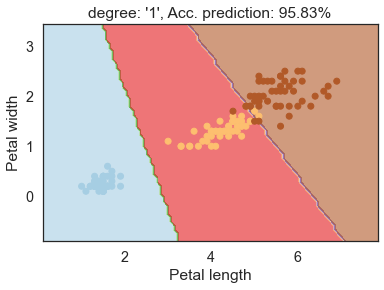

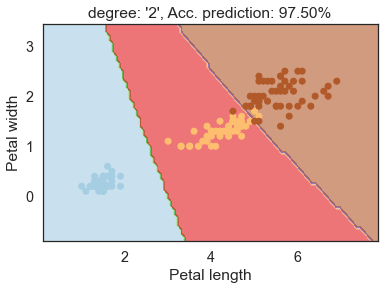

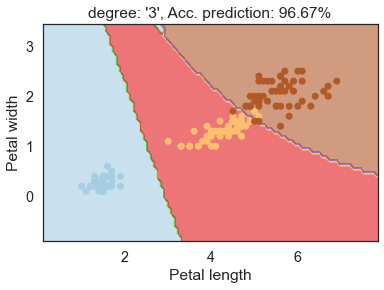

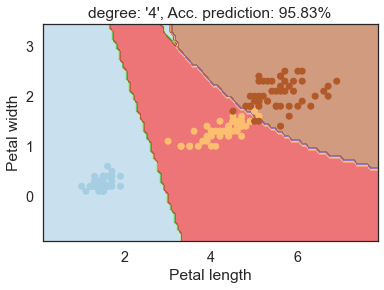

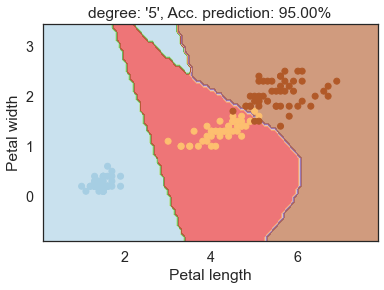

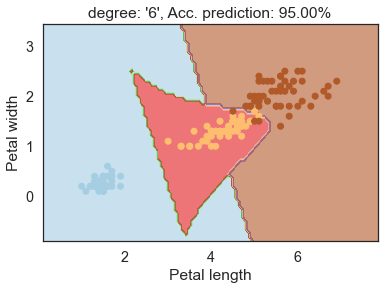

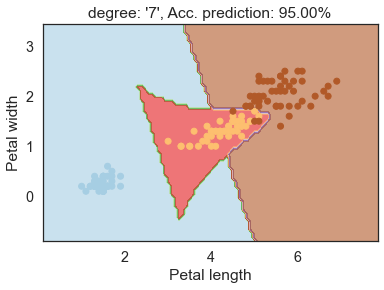

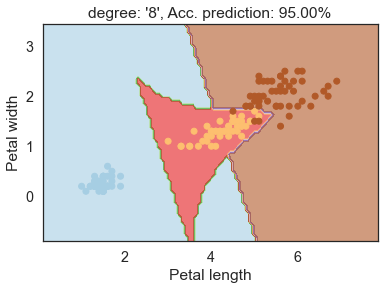

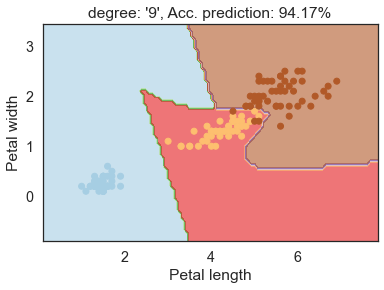

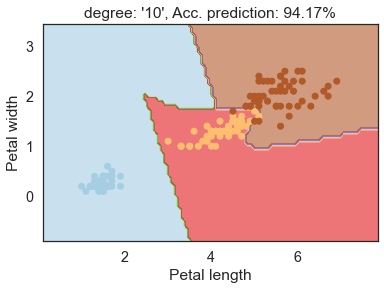

In [ ]:
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

xlabel = 'Petal length'
ylabel = 'Petal width'

for degree in degrees:
    svc_plot = svm.SVC(kernel='poly', degree=degree).fit(X_plot, y_plot)
    accuracy = crossValSVC(X_train, y_train, kernel='poly', degree=degree)
    title_str = 'degree: \''+str(degree)+'\', ' \
                 +'Acc. prediction: {:.2f}%'.format(accuracy)
    plotSVC(title_str, svc_plot, X_plot, y_plot, xlabel, ylabel)

Show the variation of the SVC parameter `degree` against the **prediction accuracy**.

As we can see, increasing the `degree` of the polynomial hyperplane leads to **overfitting** the training data.

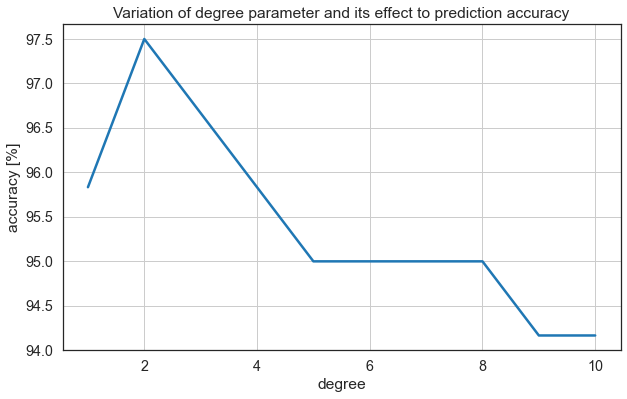

In [ ]:
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

accuracy_list = list()
for degree in degrees:
    accuracy = crossValSVC(X_train, y_train, kernel='poly', degree=degree)
    accuracy_list.append(accuracy)

plotParamsAcc(degrees, accuracy_list, 'degree', log_scale=False)

# STEP 8: Tune the ML model systematically

In the final step, two approaches to systematic hyper-parameter search are presented: **Grid Search** and **Randomized Search**. While the former exhaustively considers all parameter combinations for given values, the latter selects a number of candidates from a parameter space with a particular random distribution.

Sources:

- [3.2. Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
    - [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
    - [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)
- [Introduction to hyperparameter tuning with scikit-learn and Python](https://pyimagesearch.com/2021/05/17/introduction-to-hyperparameter-tuning-with-scikit-learn-and-python/)
    - [Abalone Dataset](https://www.kaggle.com/datasets/rodolfomendes/abalone-dataset?resource=download)
- [Hyperparameter tuning using Grid Search and Random Search: A Conceptual Guide](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35)

Import the necessary packages:

In [ ]:
# general packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd

# additional packages for grid search
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# additional packages for randomized search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

# import class MeasExecTimeOfProgram from python file MeasExecTimeOfProgramclass.py
from MeasExecTimeOfProgram_class import MeasExecTimeOfProgram

Set path and columns of the Iris dataset for import:

In [ ]:
# specify the path of the dataset
CSV_PATH = "./datasets/IRIS_flower_dataset_kaggle.csv"

Load dataset and split it into subsets for training and testing in the ratio 80% to 20%:

In [ ]:
# load the dataset, separate the features and labels, and perform a
# training and testing split using 80% of the data for training and
# 20% for evaluation
irisdata_df = pd.read_csv(CSV_PATH)

X = irisdata_df.drop('species', axis=1)
y = irisdata_df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True)

Check that the split datasets are still balanced and that no **bias** has been created by the splitting.

For this test, the previously separated labels `y_train` must be added back to the training dataset `X_train`.

In [ ]:
# make a deep copy of 'X_train'
X_train_bias_test_df = X_train.copy(deep=True)

# add list of labels to test dataframe
X_train_bias_test_df['species'] = y_train

# count unique values without missing values in a column, 
# ordered descending and normalized
X_train_bias_test_df['species'].value_counts(ascending=False, dropna=False, normalize=True)

Iris-virginica     0.358333
Iris-setosa        0.333333
Iris-versicolor    0.308333
Name: species, dtype: float64

Standardize the feature values by computing the **mean**, subtracting the mean from the data points, and then dividing by the **standard deviation**:

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#X_train

## Finding a baseline

The aim of this sub-step is to establish a baseline on the Iris dataset by training a **Support Vector Classifier (SVC)** with no hyperparameter tuning.

Train the model with **no tuning of hyperparameters** to find the baseline for later improvements:

In [ ]:
classifier = SVC(kernel = 'linear', random_state = 0)

# initiate measuring execution time
execTime = MeasExecTimeOfProgram()
execTime.start()

classifier.fit(X_train, y_train)

# print time delta
print('Execution time: {:.4f} ms'.format(execTime.stop()))

Execution time: 2.1579 ms


Evaluate our model using accuracy score:

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)

print("Accuracy score: {:.2f} %".format(acc_score.mean()*100))

Accuracy score: 100.00 %


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00         7

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



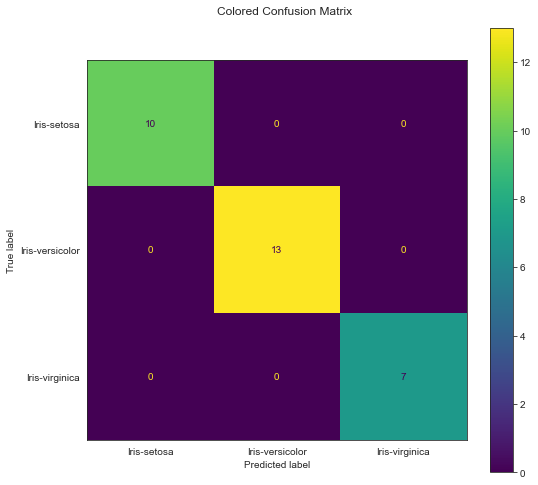

In [ ]:
sns.set_style("white")

# print colored confusion matrix
cm_colored = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

cm_colored.figure_.suptitle("Colored Confusion Matrix")
cm_colored.figure_.set_figwidth(8)
cm_colored.figure_.set_figheight(7)

cm_colored.confusion_matrix

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00         7

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



In [ ]:
classifier.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Grid Search

Initialize the SVC model and define the **space of the hyperparameters** to perform the **grid-search** over:

In [ ]:
classifier = SVC()

kernels = ["linear", "rbf", "sigmoid", "poly"]
gammas = [0.1, 1, 10, 100, 200]
cs = [0.1, 1, 5, 10, 100, 1000, 10000]

# reduce the possible polynomial degrees to reasonable values,
# since with higher degrees the calculation time increases exponentially
degrees = [1, 2, 3, 4, 5]

grid = dict(kernel=kernels, gamma=gammas, C=cs, degree=degrees)

Initialize a **cross-validation fold** and **perform a grid-search** to tune the hyperparameters:

In [ ]:
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

gridSearch = GridSearchCV(estimator=classifier, param_grid=grid, n_jobs=-1,
                          cv=cvFold, scoring="accuracy")

# initiate measuring execution time
execTime = MeasExecTimeOfProgram()
execTime.start()

searchResults = gridSearch.fit(X_train, y_train)

# print time delta
print('Execution time: {:.2f} s'.format(execTime.stop()/1000))

Execution time: 44.72 s


Extract the best model and evaluate it:

In [ ]:
from sklearn.metrics import accuracy_score

bestModel = searchResults.best_estimator_

y_pred = bestModel.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)

print("Accuracy score: {:.2f} %".format(acc_score.mean()*100))

Accuracy score: 96.67 %


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.88      1.00      0.93         7

       accuracy                           0.97        30
      macro avg       0.96      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



In [ ]:
bestModel.get_params()

{'C': 5,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 1,
 'gamma': 0.1,
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Randomized Search

Initialize the SVC model and define the **space of the hyperparameters** to perform the **randomized-search** over:

In [ ]:
classifier = SVC()

kernels = ["linear", "rbf", "sigmoid", "poly"]
gammas = [0.1, 1, 10, 100, 200]
cs = [0.1, 1, 5, 10, 100, 1000, 10000]

# reduce the possible polynomial degrees to reasonable values,
# since with higher degrees the calculation time increases exponentially
degrees = [1, 2, 3, 4, 5]

grid = dict(kernel=kernels, gamma=gammas, C=cs, degree=degrees)

Initialize a **cross-validation fold** and **perform a randomized-search** to tune the hyperparameters:

In [ ]:
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

randomSearch = RandomizedSearchCV(estimator=classifier, n_jobs=-1,
                                  cv=cvFold, param_distributions=grid,
                                  scoring="accuracy")

# initiate measuring execution time
execTime = MeasExecTimeOfProgram()
execTime.start()

searchResults = randomSearch.fit(X_train, y_train)

# print time delta
print('Execution time: {:.3f} s'.format(execTime.stop()/1000))

Execution time: 0.421 s


Extract the best model and evaluate it:

In [ ]:
from sklearn.metrics import accuracy_score

bestModel = searchResults.best_estimator_

y_pred = bestModel.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)

print("Accuracy score: {:.2f} %".format(acc_score.mean()*100))

Accuracy score: 96.67 %


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.88      1.00      0.93         7

       accuracy                           0.97        30
      macro avg       0.96      0.97      0.96        30
   weighted avg       0.97      0.97      0.97        30



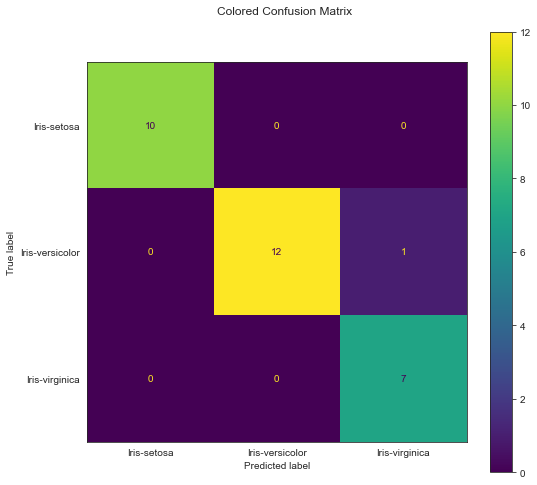

In [ ]:
sns.set_style("white")

# print colored confusion matrix
cm_colored = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

cm_colored.figure_.suptitle("Colored Confusion Matrix")
cm_colored.figure_.set_figwidth(8)
cm_colored.figure_.set_figheight(7)

cm_colored.confusion_matrix

plt.tight_layout()
plt.show()

In [ ]:
bestModel.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 1,
 'gamma': 1,
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}